# Working with real-world data

As an example of how `pymnet` can be used to analyze real-world data, we take a look at data that *interesting* data that actually *matters*. 
The Convention on International Trade in Endangered Species of Wild Fauna and Flora (CITES) is an international agreement governing the *legal* trade in endangered species. 
Data on trade in endangered species is crucial for monitoring progress toward the United Nations' Sustainable Development Goal 15, and the [CITES database](https://trade.cites.org/) makes such data available at a very high granularity, accompanied by great [documentation](https://trade.cites.org/cites_trade_guidelines/en-CITES_Trade_Database_Guide.pdf). 

To keep matters simple, we analyze an excerpt from the database, which is shipped with this tutorial for convenience and licensed under the [UN Data License](https://data.un.org/Host.aspx?Content=UNdataUse) (see [here](https://github.com/mnets/pymnet/tree/master/doc/tutorials/preprocessing.py) for a documentation of the preprocessing steps). 
More precisely, we take a look at the trade in endangered species for two different years (2010 and 2020), focusing on two different trade terms (live specimens and meat), and restricting ourselves to species taken from the wild and traded for commercial purposes. 

Our multilayer-network model will be the following:
- Nodes: importing and exporting countries or territories (represented by their ISO-2 codes)
- Aspects:
    - Year (two elementary layers: 2010 and 2020)
    - (Trade) Term (two elementary layers: "live" and "meat")
- Edges: trade volume between countries, measured in number of specimens ("live") or kg ("meat"), where we use the maximum amount reported by any of the trade parties as the edge weight

## Example data

First, we take a look at our data using `pandas`.  
Note that we need to be careful with the NA-handling, since in the ISO-2 country codes, "NA" stands for "Namibia":

In [1]:
import pandas as pd

df = pd.read_csv('cites-trades_commercial_live-meat_2010-2020.csv', na_values='null', keep_default_na=False)
df.head()

,Year,Term,Importer,Exporter,Max_reported_quantity,Unit
0,2010,live,AD,ES,26.0,Number of specimens
1,2010,live,AE,AT,74.0,Number of specimens
2,2010,live,AE,BE,609.0,Number of specimens
3,2010,live,AE,BH,2258.0,Number of specimens
4,2010,live,AE,BJ,1912.0,Number of specimens


## Network modeling

Now, let us transform this data into a `MultilayerNetwork` using `pymnet` (programmatic I/O from and to CSV files will become available soon):

In [2]:
from pymnet import *

In [3]:
aspect_columns_1 = ["Year", "Term"]
aspect_columns_2 = ["Year", "Term"]
node_columns = ["Exporter", "Importer"]
weight_column = "Max_reported_quantity"
directed = True
fully_interconnected = False

assert len(aspect_columns_1) == len(aspect_columns_2)
net = MultilayerNetwork(aspects=len(aspect_columns_1), directed=directed, fullyInterconnected=fully_interconnected)
for idx, row in df.iterrows():
    net[row[node_columns[0]],*[row[aspect] for aspect in reversed(aspect_columns_1)]
                               ][row[node_columns[1]],*[row[aspect] for aspect in reversed(aspect_columns_2)]] = row[weight_column]

In [4]:
assert len(net.edges) == len(df)
len(net.edges)

3378

## Network visualization

Plotting in `pymnet` currently supports only directed networks with a single aspect. 
Therefore, we first aggregate the bidirectional trade flows between trade partners and create separate networks for each year (2010 and 2020; first aspect).

In [5]:
df["IE"] = [tuple(sorted([x,y])) for x,y in zip(df.Importer,df.Exporter)]
df_undir = df.groupby(["IE","Year"]).agg(dict(Importer="min", Exporter="max",Term="min",Unit="min",Max_reported_quantity="sum")).reset_index()

net2010 = MultiplexNetwork(directed=False, fullyInterconnected=False, couplings="categorical")
net2020 = MultiplexNetwork(directed=False, fullyInterconnected=False, couplings="categorical")

for idx, row in df_undir.query("Exporter != Importer and ((Max_reported_quantity >= 1000000 and Term == 'live') or "
               "(Max_reported_quantity >= 1000 and Term == 'meat'))").iterrows():
    term = row["Term"]
    if row[aspect_columns_1[0]] == 2010:
        net2010[row[node_columns[0]],*[row[aspect] for aspect in reversed(aspect_columns_1[1:])]
                                   ][row[node_columns[1]],*[row[aspect] for aspect in reversed(aspect_columns_2[1:])]] = row[weight_column] / (1000 if term == "live" else 1)
    else:
        net2020[row[node_columns[0]],*[row[aspect] for aspect in reversed(aspect_columns_1[1:])]
                                   ][row[node_columns[1]],*[row[aspect] for aspect in reversed(aspect_columns_2[1:])]] = row[weight_column]  / (1000 if term == "live" else 1)

Now, for each year, we can visualize each trade term ("live" and "meat; second aspect) as a separate layer of a single-aspect network. 
We also ensure that the nodes are aligned across all networks and layers, highlight OECD countries, and do scale nodes by degree as well as edge widths and edge colors by trade flow:

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import product

In [7]:
def get_width(e):
    weight = e[-1]
    return max(1,min(weight / 1000, 5))

In [8]:
G = nx.Graph()
nodes = sorted(set(df_undir.Importer) | set(df_undir.Exporter))
G.add_nodes_from(nodes)
pos = nx.circular_layout(G)

In [9]:
oecd = ['AU', 'AT', 'BE', 'CA', 'CL', 'CO', 'CR', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IL', 'IT', 'JP', 'LV',
  'LT', 'LU', 'MX', 'NL', 'NZ', 'NO', 'PL', 'PT', 'SK', 'SI', 'KR', 'ES', 'SE', 'CH', 'TR', 'GB', 'US']

In [10]:
config = dict(layout="circular",
           nodeSizeRule={"rule":"degree", "propscale":0.05},
           nodeColorDict={(x,y):"crimson" for x,y in product(oecd, ["live","meat"])},
           edgeColorRule={"rule":"edgeweight", "colormap":"viridis", "scaleby":5e-5,},
           edgeWidthDict={((e[0],e[2]),(e[1],e[3])):get_width(e) for e in list(net2010.edges) + list(net2020.edges)},
           defaultLayerColor="#DDDDDD",
           defaultLayerLabelLoc=(0.95,0.95), 
           defaultNodeLabelColor="black",
              layergap=1.5, 
              nodeCoords=pos,
              defaultLayerAlpha=0.5
              )

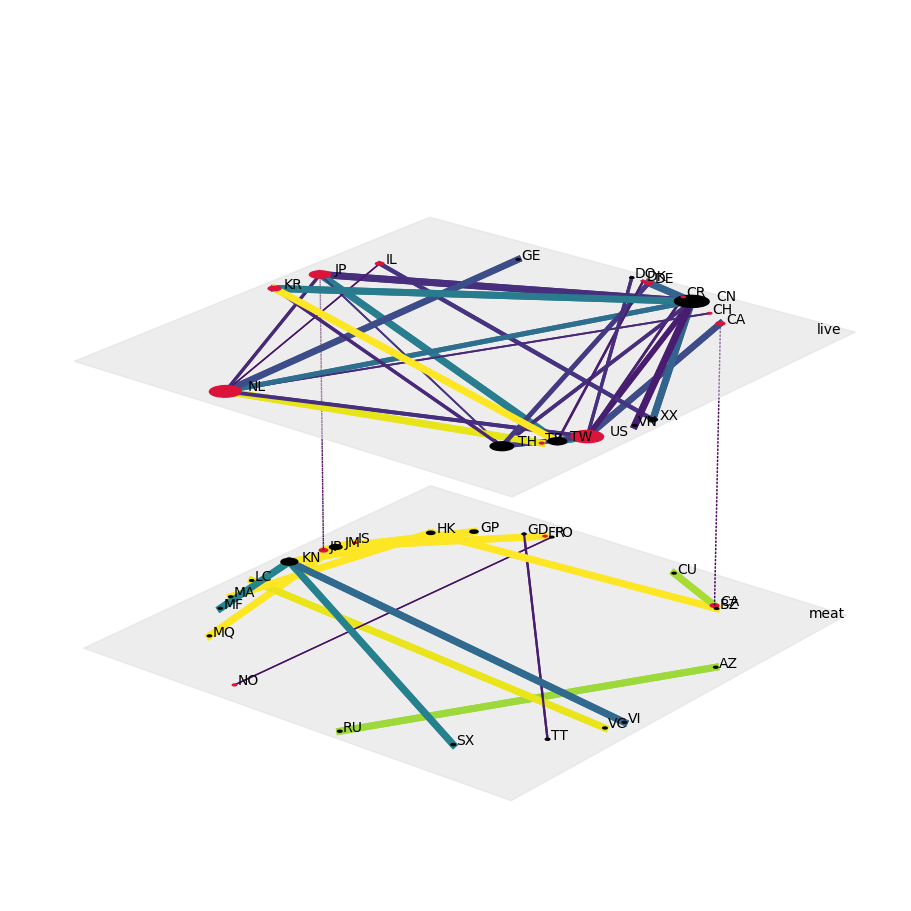

In [11]:
fig, ax = plt.subplots(1,1,figsize=(9,9),subplot_kw=dict(projection='3d'), constrained_layout=True)
draw(net2010, **config, ax=ax)
plt.savefig("cites-trades_commercial_live-meat_2010.png", bbox_inches='tight', transparent=True)

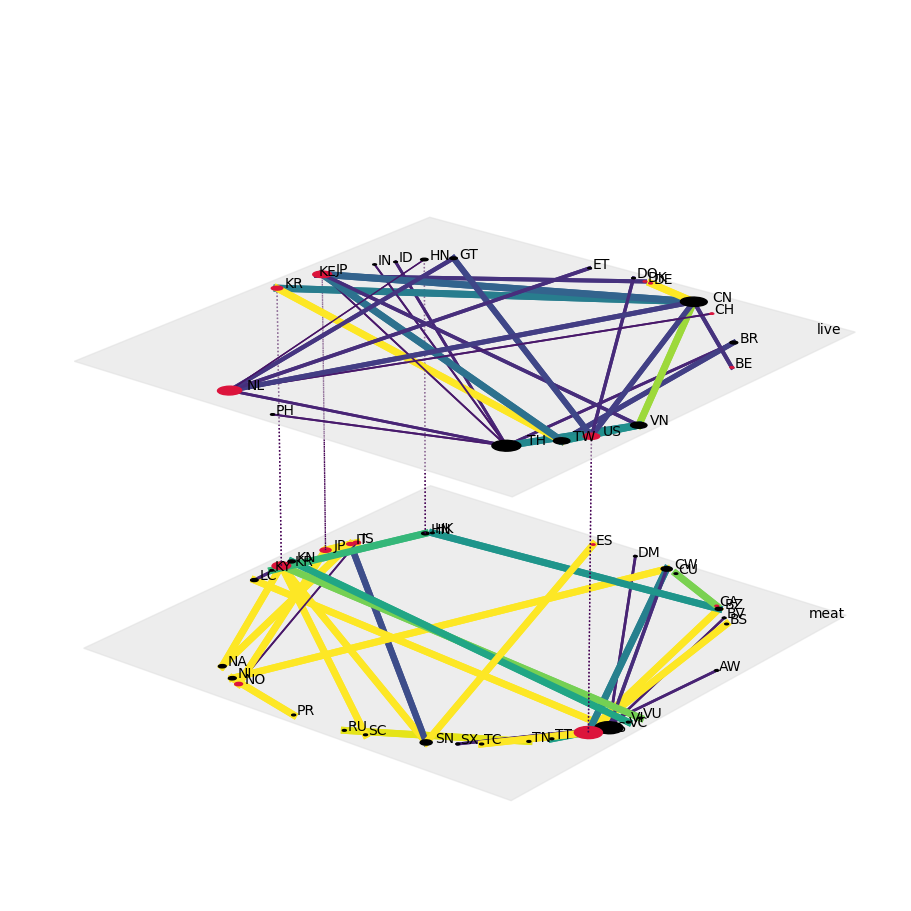

In [12]:
fig, ax = plt.subplots(1,1,figsize=(9,9),subplot_kw=dict(projection='3d'), constrained_layout=True)
draw(net2020, **config, ax=ax)
plt.savefig("cites-trades_commercial_live-meat_2020.png", bbox_inches='tight', transparent=True)